# Minimum viable products

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

import torch

## MNIST change detection

In [2]:
from change_detection import RateFunctionTest, ScoreTest

from cgf_network import CGF_ICNN, ConditionalCGF
from models.simple_examples import Basic_MNIST

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from functools import partial

classifier_ckpt = './learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'
conditional_ckpt = 'trainedParameters/MNIST_initial/step2_MNIST/validation-epoch=128-step=8062500.ckpt'

mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
mnist_model.setup()
mnist_model.fit_activity_transform(mnist_model.data_train)

activity_dataset_train = mnist_model.internal_activity_dataset(mnist_model.data_train)


mnist_test_data = MNIST('~/Datasets/', download=True, train=False,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )
activity_dataset_test = mnist_model.internal_activity_dataset(mnist_test_data)


mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_dataset_train[:][0])
conditional_mnist = ConditionalCGF.load_from_checkpoint(conditional_ckpt,
                                                        dataset_to_model=activity_dataset_train)

To do: binomial confidence intervals

In [3]:
def run_tests(get_samples, tests, N_trials=1000):
    """ runs N_trials replicates of the tests
    """
    results = np.zeros(len(tests))

    for rep in range(N_trials):
        data = get_samples()
        for i in range(len(tests)):
            results[i] += int(tests[i].is_different(data).item())

    return results / N_trials


def make_sampler(dataset, N_sample, target_weights={i:1. for i in range(10)}):
    """ generates a sampler from the dataset """
    inputs, targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], targets), dtype=float)
    probs = probs / sum(probs)

    def sample():
        inds = np.random.choice(inputs.shape[0], N_sample, p=probs)
        #return inputs[inds]
        return inds

    return sample



In [4]:
n_samples = 100

sample_gen = make_sampler(activity_dataset_test, n_samples)

scoretest = ScoreTest(mnist_cgf, n_samples, 0.5)
ratetest = RateFunctionTest(mnist_cgf, n_samples, 0.5)

[-inf, inf] [-inf, inf]
[-inf, 1] [-inf, 1.0000000000000002]
[-inf, 0.5] [-inf, 1.0]
[-inf, 0.25] [-inf, 0.9917063954859384]
[0.125, 0.25] [0.3405331452740774, 0.9917063954859384]
[0.125, 0.1875] [0.3405331452740774, 0.8651791448617636]
[0.125, 0.15625] [0.3405331452740774, 0.6557941213910912]
[0.125, 0.140625] [0.3405331452740774, 0.507993620311183]
[0.1328125, 0.140625] [0.424317390185862, 0.507993620311183]
[0.13671875, 0.140625] [0.46684418723925425, 0.507993620311183]
[0.138671875, 0.140625] [0.4869800139319659, 0.507993620311183]


KeyboardInterrupt: 

In [ ]:
run_tests(sample_gen, [scoretest, ratetest], N_trials=50)

The results seem a bit uncalibrated. Probably due to importance sampling small numbers of datapoints?

Also, gotta check the score test, which seems to produce little that is 

### Can I just make ROC curves by adjusting the rate function cutoff?

Note that the determinant can make a significant contribution to the shape of the probability distribution, so it might need to be included in the ROC curve values.

#### Contribution of the determinant term

In [4]:
def limiting_density(mnist_cgf, mus):
    """ Model based asymptotic pdf of the mean """
    d = 28
    n_samples = 1

    thetas, Is = mnist_cgf.dual_opt(mus)
    dets = torch.det(mnist_cgf.hess(thetas))
    
    log_density = (d/2) * np.log(n_samples / (2 * torch.pi)) \
        - 0.5*torch.log(dets) - n_samples*Is

    return torch.exp(log_density).detach()


In [5]:
inputs, targets = activity_dataset_train[0:5000]
thetas, Is = mnist_cgf.dual_opt(inputs)

In [6]:
log_det = torch.logdet( mnist_cgf.hess(thetas.detach()))

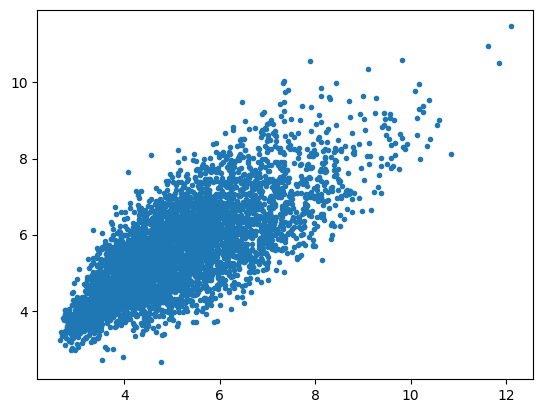

In [7]:
plt.plot(torch.norm(inputs, dim=1), Is.detach(), '.')

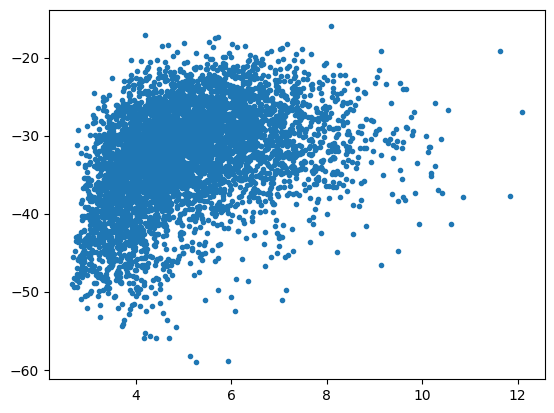

In [8]:
plt.plot(torch.norm(inputs, dim=1), log_det.detach(), '.')

In [9]:
pdf = limiting_density(mnist_cgf, inputs)

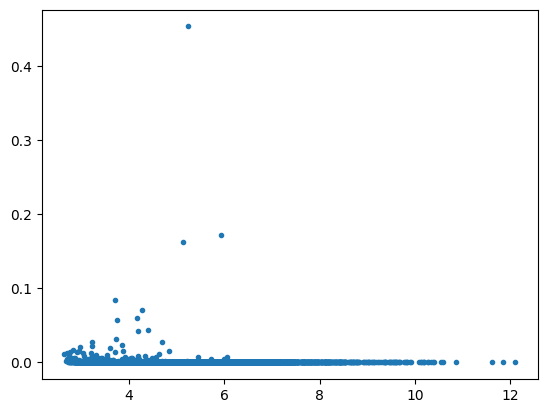

In [10]:
plt.plot(torch.norm(inputs, dim=1), pdf.detach(), '.')

The determinant is not strictly increasing in norm

Plotting against the norms is a very rough visualization method.

#### ROC analysis

In [11]:
inputs, targets = activity_dataset_train[0:5000]
target_weights={i:1. for i in range(10)}

probs = np.fromiter(map(lambda x: target_weights[x.item()], targets), dtype=float)
probs = probs / sum(probs)


inds = np.random.choice(inputs.shape[0], 100, p=probs)



In [12]:
indices = np.random.choice(inputs.shape[0], (10, 100), p=probs)

In [13]:
indices.shape

(10, 100)

In [14]:
inputs[indices].shape

torch.Size([10, 100, 28])

In [15]:
def sample_means(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, _ = dataset[indices]

    return activity.mean(1)
    

In [16]:
means = sample_means(activity_dataset_train, 100, 1000)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 0
alt_weights[8] = 0
means_alternate = sample_means(activity_dataset_train, 100, 1000, target_weights=alt_weights)

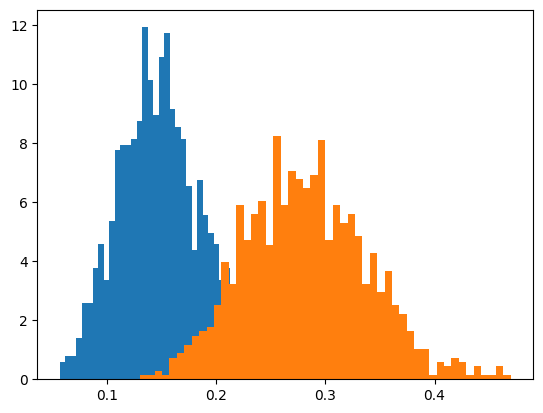

In [17]:
plt.hist( mnist_cgf.dual_function(means).detach(), bins=50, density=True )
plt.hist( mnist_cgf.dual_function(means_alternate).detach(), bins=50, density=True );

These look reasonably distinguishable.

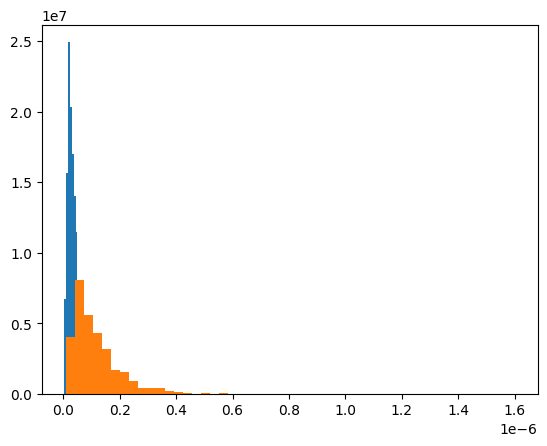

In [18]:
density = limiting_density(mnist_cgf, means)
density_alternate = limiting_density(mnist_cgf, means_alternate)

plt.hist( density_alternate.detach(), bins=50, density=True );
plt.hist( density.detach(), bins=50, density=True );

Also fairly distinguishable.

In [19]:
activity_mean = activity_dataset_train[:][0].mean(0)
activity_cov =  1./100 * activity_dataset_train[:][0].T.cov()
inv_cov = torch.linalg.inv(activity_cov)

def normal_score(means):
    distance_to_mean = means - activity_mean
    return torch.einsum('Nx, xy, Ny -> N', distance_to_mean, inv_cov, distance_to_mean)

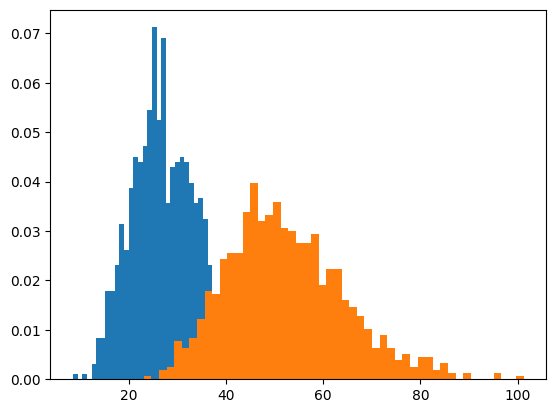

In [20]:
score = normal_score(means)
score_alternate = normal_score(means_alternate)

plt.hist( score.detach(), bins=50, density=True );
plt.hist( score_alternate.detach(), bins=50, density=True );

Similar. Now we can make ROC curves from these.

In [21]:
score_plus = mnist_cgf.dual_function(means).detach()
score_minus = mnist_cgf.dual_function(means_alternate).detach()

In [22]:
min_score = min([score_plus.min(), score_minus.min()])
max_score = max([score_plus.max(), score_minus.max()])

In [23]:
true_plus = []
false_plus = []

for score_threashold in np.linspace(min_score, max_score, 500):
    true_plus.append( (score_plus < score_threashold).sum()/ 1000)
    false_plus.append( (score_minus < score_threashold).sum()/ 1000)

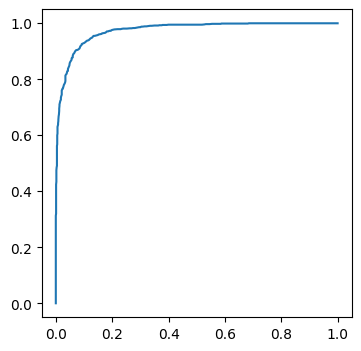

In [24]:
figsize(4,4)
plt.plot(false_plus, true_plus)

In [25]:
def make_ROC(scores_plus, scores_minus):
    """ ROC plots for scores """
    min_score = min([scores_plus.min(), scores_minus.min()])
    max_score = max([scores_plus.max(), scores_minus.max()])
    
    true_plus = []
    false_plus = []
    
    for score_threashold in np.linspace(min_score, max_score, 500):
        true_plus.append( (scores_plus < score_threashold).sum() / scores_plus.shape[0])
        false_plus.append( (scores_minus < score_threashold).sum() / scores_minus.shape[0])
        
    return true_plus, false_plus

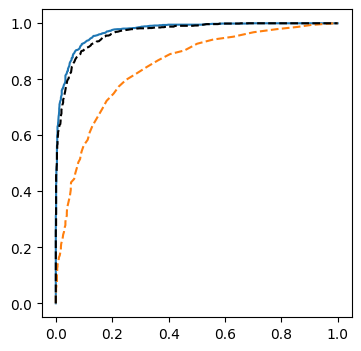

In [26]:
true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_density(mnist_cgf, means).detach(), -limiting_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')


Promising so far.
The main question is why the density underperforms. Could this be the result of round-off error? (Moving to log density could help)

In [27]:
def limiting_log_density(mnist_cgf, mus):
    """ Model based asymptotic pdf of the mean """
    d = 28
    n_samples = 100

    thetas, Is = mnist_cgf.dual_opt(mus)
    logdets = torch.logdet(mnist_cgf.hess(thetas))
    
    return  - 0.5*logdets - n_samples*Is

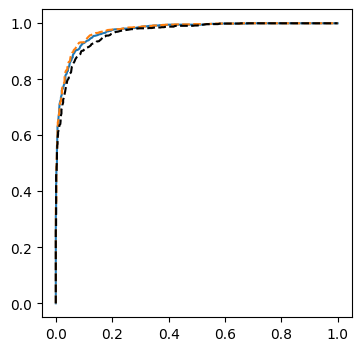

In [28]:
true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')


Yes. It was round-off error

More subtile changes in the distribution

In [29]:
means = sample_means(activity_dataset_train, 100, 1000)
alt_weights={i:2. for i in range(10)}
alt_weights[2] = 3
alt_weights[4] = 3
means_alternate = sample_means(activity_dataset_train, 100, 1000, target_weights=alt_weights)

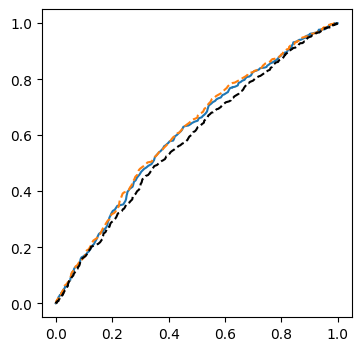

In [30]:
true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

Yikes. Bad performance.

Subtile difference, more samples

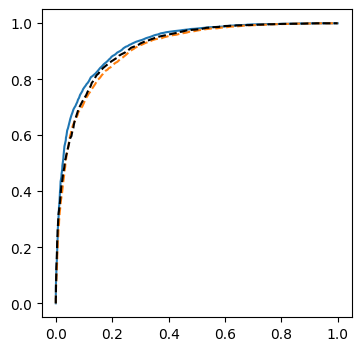

In [31]:
means = sample_means(activity_dataset_train, 1000, 5000)
alt_weights={i:2. for i in range(10)}
alt_weights[2] = 3
alt_weights[4] = 3
means_alternate = sample_means(activity_dataset_train, 1000, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

Back up.

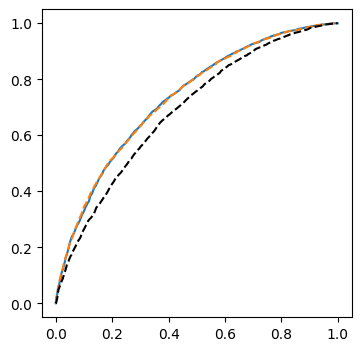

In [32]:
means = sample_means(activity_dataset_train, 300, 5000)
alt_weights={i:2. for i in range(10)}
alt_weights[2] = 3
alt_weights[4] = 3
means_alternate = sample_means(activity_dataset_train, 300, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

This is showing the main advantage of the method: good performance at low sample sizes.

Big differences again:

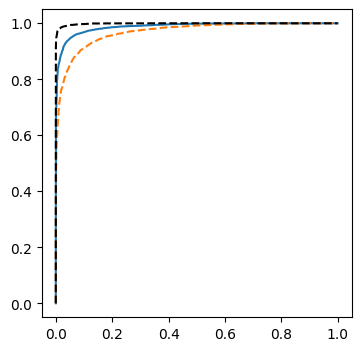

In [33]:
means = sample_means(activity_dataset_train, 300, 5000)
alt_weights={i:2. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
means_alternate = sample_means(activity_dataset_train, 300, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

Interesting: the normal dominates here.

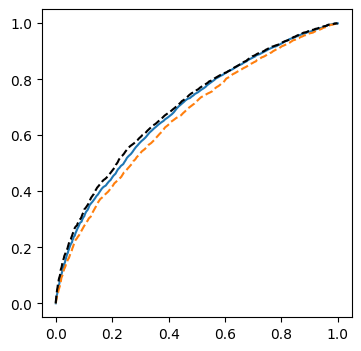

In [34]:
means = sample_means(activity_dataset_train, 50, 5000)
alt_weights={i:2. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
means_alternate = sample_means(activity_dataset_train, 50, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

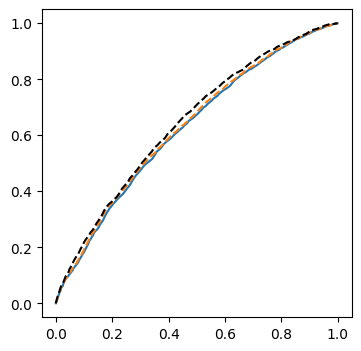

In [35]:
means = sample_means(activity_dataset_train, 10, 5000)
alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[3] = 2
alt_weights[9] = 0
alt_weights[8] = 0
means_alternate = sample_means(activity_dataset_train, 10, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

They do underperform a simple normal distribution in some places.

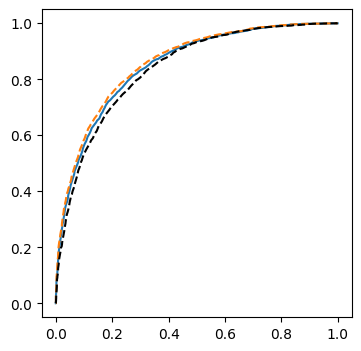

In [36]:
means = sample_means(activity_dataset_test, 40, 5000)
alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[3] = 2
alt_weights[9] = 0
alt_weights[8] = 0
means_alternate = sample_means(activity_dataset_test, 40, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(-limiting_log_density(mnist_cgf, means).detach(), -limiting_log_density(mnist_cgf, means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

In summary: the CGF approach is not clearly superior to normal across all conditions.
Drastic differences, large sample sizes, normal can be clearly superior. For subtile differences, small sample sizes, it can be better...

Including the determinant term doesn't clearly help, and sometimes hurts.

#### Using torchmetrics:

In [37]:
from torchmetrics import AUROC

In [38]:
pos = mnist_cgf.dual_function(means).detach()
neg = mnist_cgf.dual_function(means_alternate).detach()

In [39]:
preds = torch.concat([pos, neg])
targets = torch.concat([torch.ones_like(pos), torch.zeros_like(neg)])

In [40]:
preds = 1 - (preds - preds.min()) / (preds.max() - preds.min())
per_element= torch.stack([preds, 1-preds], dim=1)

In [41]:
auroc = AUROC(task='binary')

In [42]:
auroc(preds, targets)

tensor(0.8501)

Direct integration

In [59]:
from scipy import integrate

integrate.trapezoid(true_plus, x= false_plus)

np.float32(0.8499606)

Probabilistic definition:

In [64]:
pos_ind = np.random.choice(pos.shape[0], 30000)
neg_ind = np.random.choice(neg.shape[0], 30000)

In [65]:
(pos[pos_ind] < neg[neg_ind]).sum() / 30000

tensor(0.8508)

Looks good.

#### To do 01/26:

Comparison of AUROC under different changes in probability density, with different numbers of samples

Comparison to a simple method (eg. distribution of outputs)

In [95]:
# same as above
def sample_means(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, _ = dataset[indices]

    return activity.mean(1)


def limiting_neg_log_density(mus):
    """ Model based asymptotic pdf of the mean """
    d = 28
    n_samples = 100

    thetas, Is = mnist_cgf.dual_opt(mus)
    logdets = torch.logdet(mnist_cgf.hess(thetas))
    
    return  0.5*logdets + n_samples*Is

activity_mean = activity_dataset_train[:][0].mean(0)
activity_cov =  1./100 * activity_dataset_train[:][0].T.cov()
inv_cov = torch.linalg.inv(activity_cov)

def normal_score(means):
    distance_to_mean = means - activity_mean
    return torch.einsum('Nx, xy, Ny -> N', distance_to_mean, inv_cov, distance_to_mean)



# new
from torchmetrics import AUROC

def compute_auROC(detection_function, pos_means, neg_means):
    """ computes the auROC for a given detection_function, where rejection occurs if the
        output is greater than some threashold 
    """
    pos_outputs = detection_function(pos_means).detach()
    neg_outputs = detection_function(neg_means).detach()

    # convert into 'probability-like' points, ranging from 0 to 1
    preds = torch.concat([pos_outputs, neg_outputs])
    targets = torch.concat([torch.ones_like(pos_outputs), torch.zeros_like(neg_outputs)])

    preds = 1 - (preds - preds.min()) / (preds.max() - preds.min())

    auroc = AUROC(task='binary')
    return auroc(preds, targets)


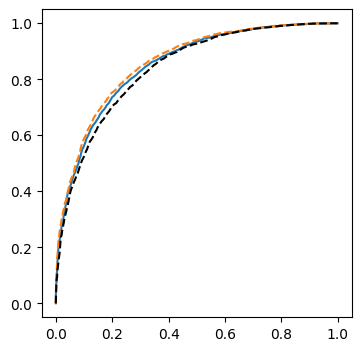

In [152]:
means = sample_means(activity_dataset_test, 40, 5000)
alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[3] = 2
alt_weights[9] = 0
alt_weights[8] = 0
means_alternate = sample_means(activity_dataset_test, 40, 5000, target_weights=alt_weights)

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate)

true_prob, false_prob = make_ROC(limiting_neg_log_density(means).detach(), 
                                 limiting_neg_log_density(means_alternate).detach())
plt.plot(false_prob, true_prob, '--')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k')

In [154]:
compute_auROC(mnist_cgf.dual_function, means, means_alternate)

tensor(0.8635)

In [155]:
compute_auROC(normal_score, means, means_alternate)

tensor(0.8561)

In [156]:
compute_auROC(limiting_neg_log_density, means, means_alternate)

tensor(0.8725)

looks good.

Theoretical best based on targets:

In [250]:
def sample_means_targets(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds = len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]

    return activity.mean(1), targets

In [260]:
from torch.distributions import Multinomial

def theoretical_max(targets):
    """ Uses ground truth targets to determine theoretical best ROC curves """
    probs = torch.ones(10) / 10.
    multinom = Multinomial(total_count=targets.shape[1], probs=1./ 10 * torch.ones(10))

    counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)
    return -multinom.log_prob(counts)
    

#### To do:

Balance the target frequency in the training data.

In [261]:
activity, targets = activity_dataset_test[:]
inds = torch.concat([(targets == i).nonzero().squeeze()[0:890] for i in range(10)])
print(torch.bincount(targets[inds]))

balanced_dataset = torch.utils.data.TensorDataset(activity[inds], targets[inds])


alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[3] = 2
alt_weights[9] = 0
alt_weights[8] = 0
means, targets = sample_means_targets(balanced_dataset, 40, 5000)
means_neg, targets_neg = sample_means_targets(balanced_dataset, 40, 5000, target_weights=alt_weights)

tensor([890, 890, 890, 890, 890, 890, 890, 890, 890, 890])


/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19588/3014238921.py:8: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


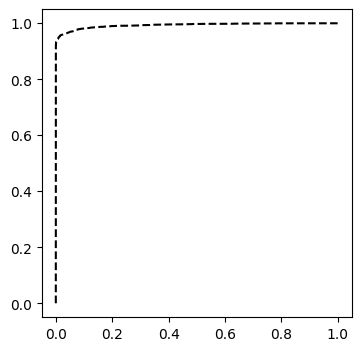

In [262]:
true_norm, false_norm = make_ROC(theoretical_max(targets), theoretical_max(targets_neg))
plt.plot(false_norm, true_norm, '--k')

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19588/3014238921.py:8: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


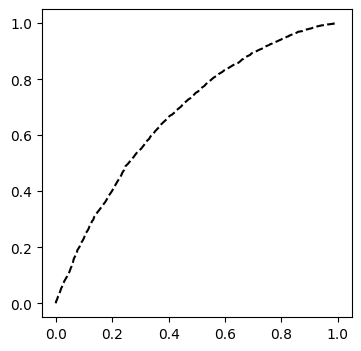

In [264]:
alt_weights={i:2. for i in range(10)}
alt_weights[2] = 3
alt_weights[4] = 3

means, targets = sample_means_targets(balanced_dataset, 100, 5000)
means_neg, targets_neg = sample_means_targets(balanced_dataset, 100, 5000, target_weights=alt_weights)
true_norm, false_norm = make_ROC(theoretical_max(targets), theoretical_max(targets_neg))
plt.plot(false_norm, true_norm, '--k')

In these very subtle cases, plotting the theoretical max will be helpful

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19588/3014238921.py:8: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


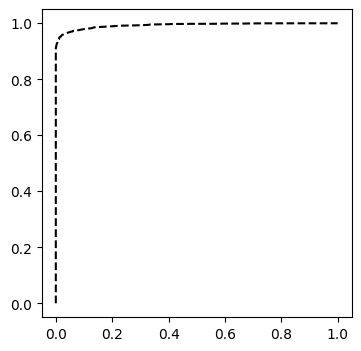

In [380]:
alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[3] = 2
alt_weights[9] = 0
alt_weights[8] = 0

means, targets = sample_means_targets(balanced_dataset, 40, 5000)
means_neg, targets_neg = sample_means_targets(balanced_dataset, 40, 5000, target_weights=alt_weights)
true_norm, false_norm = make_ROC(theoretical_max(targets), theoretical_max(targets_neg))
plt.plot(false_norm, true_norm, '--k')

mmmm. For less subtile cases, this isn't informative.

#### Same ROC curves for model outputs:

In [378]:
def sample_model_outputs(N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Samples outputs of the model itself.
    """
    inputs, targets = next(iter(torch.utils.data.DataLoader(mnist_model.data_train, batch_size=len(mnist_model.data_train))))
    # balance the dataset
    inds = torch.concat([(targets == i).nonzero().squeeze()[0:890] for i in range(10)])
    inputs = inputs[inds]
    targets = targets[inds]

    probs = np.fromiter(map(lambda x: target_weights[x.item()], targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(inds.shape[0], (num_samples, N_mean), p=probs).reshape(-1)

    decoded = torch.argmax(mnist_model.forward(inputs[indices].to(mnist_model.device)), axis=1)
    
    return decoded.cpu().reshape(num_samples, N_mean), targets[indices].reshape(num_samples, N_mean)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19588/3014238921.py:8: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


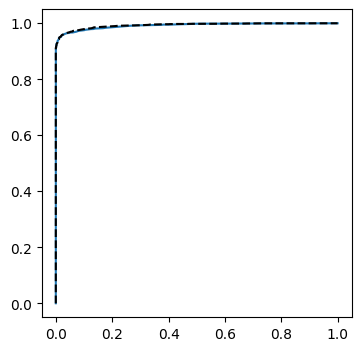

In [381]:
alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[3] = 2
alt_weights[9] = 0
alt_weights[8] = 0

decoded, targets = sample_model_outputs(40, 5000)
decoded_neg, targets_neg = sample_model_outputs(40, 5000, target_weights=alt_weights)
true_norm_emp, false_norm_emp = make_ROC(theoretical_max(targets), theoretical_max(targets_neg))
plt.plot(false_norm_emp, true_norm_emp)
plt.plot(false_norm, true_norm, '--k')

It achieves pretty close to theoretical max accuracy. After all, the test accuracy is high.